In [ ]:
import torch
import torchvision
import PIL
import os
import torch.nn as nn
import matplotlib.pyplot as plt

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [ ]:
class ImageSet(torch.utils.data.Dataset):
    def __init__(self, folder_path, transform=None):
        self.folder_path=folder_path
        self.filenames = [filename for filename in os.listdir(self.folder_path)]
        self.transform = transform

    def __len__(self):
        return len(self.filenames)

    def __getitem__(self, idx):
        #file_extension = os.path.join(str(), ".jpg")
        image_path = os.path.join(self.folder_path, self.filenames[idx])
        image=PIL.Image.open(image_path).convert("RGB")
        if self.transform:
            image=self.transform(image)
        image = image.to(device)
        image.requires_grad_()
        image.to(device)
        return image

data = ImageSet("/content/drive/MyDrive/Pokemon/pokemon_jpg", torchvision.transforms.ToTensor())
print(len(data))
dataloader = torch.utils.data.DataLoader(data, batch_size=16, shuffle=True)
preploader = torch.utils.data.DataLoader(data, batch_size=8, shuffle=True)

819


In [ ]:
class Generator(nn.Module):
    def __init__(self, device):
        super().__init__()
        self.device = device
        self.model = nn.Sequential(
            nn.Linear(100, 512),
            nn.LeakyReLU(0.2),
            nn.BatchNorm1d(512),
            nn.Linear(512, 1024),
            nn.LeakyReLU(0.2),
            nn.BatchNorm1d(1024),
            nn.Linear(1024, 1024),
            nn.LeakyReLU(0.2),
            nn.BatchNorm1d(1024),
            nn.Linear(1024, 3 * 256 * 256),
            nn.Sigmoid()
        ).to(device)

    def forward(self, entree):
        image = self.model(entree)
        return image.view(entree.size()[0], 3, 256, 256)

generateur = Generator(device)

In [ ]:
mean_images = []
for i, images in enumerate(preploader):
    mean = images.mean(dim=0)
    mean_images.append(mean)

In [ ]:
print(mean_images[0].shape)

torch.Size([3, 256, 256])


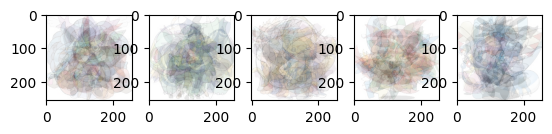

In [ ]:
fig, ax = plt.subplots(1, 5)
for i in range(5):
    image=mean_images[i]
    image = image.swapaxes(0,1).swapaxes(1,2).cpu().detach().numpy()
    ax[i].imshow(image)
plt.show()

In [ ]:
def prep_loss(result, true_image):
    return torch.sum(torch.abs(result - true_image).flatten())

In [ ]:
prep_optim = torch.optim.Adam(generateur.parameters(), lr=0.01)

coût de : 65555.4140625
coût de : 37779.9609375
coût de : 158656.59375
coût de : 35131.3984375
coût de : 36859.85546875
coût de : 157094.5
coût de : 158431.4375
coût de : 162184.3125
coût de : 153218.640625
coût de : 159501.375
coût de : 37697.3828125
coût de : 157877.171875
coût de : 34639.75390625
coût de : 150920.125
coût de : 40256.5703125
coût de : 35343.35546875
coût de : 41877.78125
coût de : 42872.5859375
coût de : 37482.7421875
coût de : 160931.03125
coût de : 37839.4453125
coût de : 161109.125
coût de : 159433.734375
coût de : 158518.90625
coût de : 165024.5625
coût de : 43209.56640625
coût de : 163901.890625
coût de : 29006.99609375
coût de : 151579.4375
coût de : 36267.625
coût de : 40003.3515625
coût de : 157019.3125
coût de : 154861.28125
coût de : 156606.71875
coût de : 159830.515625
coût de : 158010.828125
coût de : 157791.0
coût de : 160148.9375
coût de : 34357.7890625
coût de : 32945.625
coût de : 157573.59375
coût de : 42613.6328125
coût de : 157757.359375
coût de : 

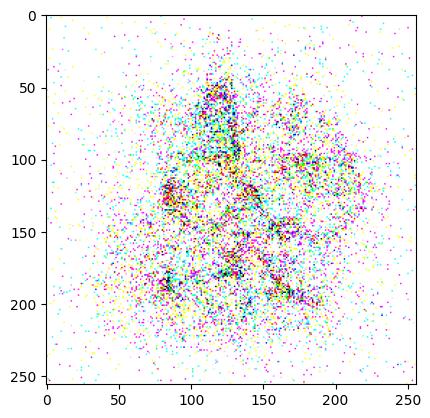

In [ ]:
generateur.train()

for _ in range(3):
    for image in mean_images[:len(mean_images)]:
        prep_optim.zero_grad()
        randn = torch.randn((2, 100)).to(device)
        im_gener = generateur.forward(randn)
        cost = prep_loss(im_gener[0], image)
        print(f"coût de : {cost}")
        cost.backward()
        prep_optim.step()
    print(f"Epoch {_+1} terminée")

rand_test = torch.randn((2, 100)).to(device)

gen_images = generateur.forward(rand_test)

image_test = gen_images[0]
image_test = torch.swapdims(image_test, 0, 1)
image_test = torch.swapdims(image_test, 1, 2)
image_test *= 255
image_test = image_test.int()
image_test = image_test.cpu()
image_test = image_test.detach().numpy()

plt.imshow(image_test)
plt.show()

In [ ]:
class Discriminator(nn.Module):
    def __init__(self, device):
        super(Discriminator, self).__init__()
        self.conv_layers = nn.Sequential(
            nn.Conv2d(3, 8, kernel_size=3, padding=1),
            nn.MaxPool2d(kernel_size=3, stride=3),
            nn.Conv2d(8, 16, kernel_size=3, padding=1),
            nn.MaxPool2d(kernel_size=3, stride=3),
            nn.Conv2d(16, 32, kernel_size=3, padding=1),
            nn.MaxPool2d(kernel_size=3, stride=3)
        )
        self.fc_layers = nn.Sequential(
            nn.Flatten(start_dim=1),
            nn.Linear(2592, 40),
            nn.Linear(40, 20),
            nn.Linear(20, 1)
        )
        self.to(device)

    def forward(self, x):
        x = self.conv_layers(x)
        x = self.fc_layers(x)
        return x

discrim = Discriminator(device)

In [ ]:
def wass_loss_d(real_scores, fake_scores):
    return fake_scores.mean() - real_scores.mean()

def wass_loss_g(fake_scores):
    return fake_scores.mean()

In [ ]:
epoch_d = 1
epoch_g = 5
lr_g = 10E-2
lr_d = 10E-4

optim_d = torch.optim.Adam(discrim.parameters(), lr=lr_d, maximize=True)
optim_g = torch.optim.Adam(generateur.parameters(), lr=lr_g)

In [ ]:
generateur.train()
discrim.train()

cost_prev = 0

for master in range(2):
    dataloader = torch.utils.data.DataLoader(data, batch_size=16, shuffle=True)

    for _ in range(epoch_d):
        for count, images in enumerate(dataloader):
            optim_d.zero_grad()

            rand_batch = torch.randn((16, 100)).to(device)
            fake_images = generateur.forward(rand_batch)
            false_score = discrim.forward(fake_images)
            authentic_score = discrim.forward(images)
            cost = wass_loss_d(authentic_score, false_score)
            if cost > 200:
                print(f"coût du discriminateur dépassée : {cost.item()}")
                break

            cost.backward()
            optim_d.step()


            print(f"{count*16}, cost du discriminateur:{(cost.item())}")


        print(f"Epoch:{_ + 1}")

    for _ in range(epoch_g):
        for count, image in enumerate(dataloader):
            optim_g.zero_grad()

            rand_batch = torch.randn((8, 100)).to(device)
            rand_images = generateur.forward(rand_batch)
            scores = discrim(rand_images)
            cost = wass_loss_g(scores)
            cost.backward()
            optim_g.step()

            print(f"count : {16*count}, cost du générateur : {cost.item(), (cost - cost_prev).item()}")
            cost_prev = cost
        print(f"Epoch : {_+1}")
    print(f"master : {master+1}")

0, cost du discriminateur:146.61941528320312
16, cost du discriminateur:172.96853637695312
coût du discriminateur dépassée : 214.49395751953125
Epoch:1
count : 0, cost du générateur : (685.6353149414062, 685.6353149414062)
count : 16, cost du générateur : (685.6351318359375, -0.00018310546875)
count : 32, cost du générateur : (685.6351318359375, 0.0)
count : 48, cost du générateur : (685.6351318359375, 0.0)
count : 64, cost du générateur : (685.6351318359375, 0.0)
count : 80, cost du générateur : (685.6351318359375, 0.0)
count : 96, cost du générateur : (685.6351318359375, 0.0)
count : 112, cost du générateur : (685.6351318359375, 0.0)
count : 128, cost du générateur : (685.6351318359375, 0.0)
count : 144, cost du générateur : (685.6351318359375, 0.0)
count : 160, cost du générateur : (685.6351318359375, 0.0)
count : 176, cost du générateur : (685.6351318359375, 0.0)
count : 192, cost du générateur : (685.6351318359375, 0.0)
count : 208, cost du générateur : (685.6351318359375, 0.0)
co

KeyboardInterrupt: 

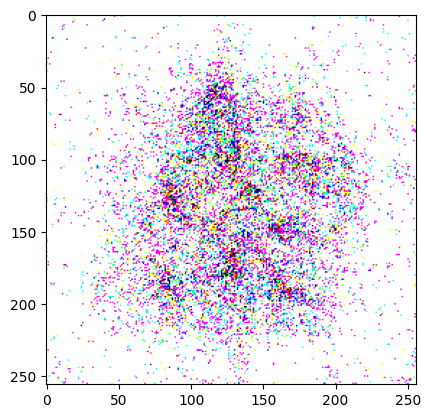

In [ ]:
rand_test = torch.randn((2, 100)).to(device)

gen_images = generateur.forward(rand_test)

image_test = gen_images[0]
image_test = torch.swapdims(image_test, 0, 1)
image_test = torch.swapdims(image_test, 1, 2)
image_test *= 255
image_test = image_test.int()
image_test = image_test.cpu()
image_test = image_test.detach().numpy()

plt.imshow(image_test)
plt.show()